# **Import libraries**

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import keras.utils as image
from sklearn.preprocessing import OneHotEncoder
from keras.src.utils import to_categorical,normalize
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import keras.layers as layers
from keras.models import Model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load Data ##

In [2]:
train_path = "/kaggle/input/dataset-nn23/dataset/train/"
test_path = "/kaggle/input/dataset-nn23/dataset/test/"

In [3]:
IMG_SIZE = 224
classes = ['1', '2', '3', '4', '5']
Input_Shape = (IMG_SIZE, IMG_SIZE, 3)
images = []
labels = []
for c in classes:
    for img in os.listdir(train_path + c):
        img = cv2.imread(train_path + c + '/' + img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img)
        labels.append(int(c))
        
images = np.array(images, dtype='float32')/255.0        

# Encoding labels 

In [4]:
onehotencoder = OneHotEncoder()
label = np.array(labels).reshape(-1,1)
labels = onehotencoder.fit_transform(label).toarray()

# Split Images and labels to train & validation 

In [5]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=42)

## Augmentation For Train ##

In [6]:
training_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest",
)

training_datagen.fit(X_train)

# **DenseNet Model**

In [7]:
NUM_EPOCHS = 100

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
# Creating Densenet121
def densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
        
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model
input_shape = IMG_SIZE, IMG_SIZE, 3
n_classes = 5
model = densenet(input_shape,n_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 56, 56, 64)           256       ['max_pooling2d[0][0]']   

# Compile Model

In [9]:
model.compile(optimizer='adam',
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

# Fit Model

In [10]:
history=model.fit(training_datagen.flow(X_train, y_train, batch_size=64),
         validation_data=(X_val, y_val),epochs=NUM_EPOCHS,steps_per_epoch=124)

Epoch 1/100
124/124 [==============================] - 223s 1s/step - loss: 1.5039 - accuracy: 0.4624 - val_loss: 1.7243 - val_accuracy: 0.2030
Epoch 2/100
124/124 [==============================] - 130s 1s/step - loss: 1.2451 - accuracy: 0.5327 - val_loss: 3.8306 - val_accuracy: 0.2071
Epoch 3/100
124/124 [==============================] - 129s 1s/step - loss: 1.1120 - accuracy: 0.5635 - val_loss: 1.2184 - val_accuracy: 0.5444
Epoch 4/100
124/124 [==============================] - 130s 1s/step - loss: 1.0436 - accuracy: 0.5955 - val_loss: 1.5569 - val_accuracy: 0.3859
Epoch 5/100
124/124 [==============================] - 131s 1s/step - loss: 1.0007 - accuracy: 0.6049 - val_loss: 1.3152 - val_accuracy: 0.5561
Epoch 6/100
124/124 [==============================] - 130s 1s/step - loss: 0.9849 - accuracy: 0.6193 - val_loss: 1.2653 - val_accuracy: 0.5015
Epoch 7/100
124/124 [==============================] - 128s 1s/step - loss: 0.9355 - accuracy: 0.6384 - val_loss: 1.5458 - val_accuracy:

# Plot the training and validation accuracy and loss at each epoch # 

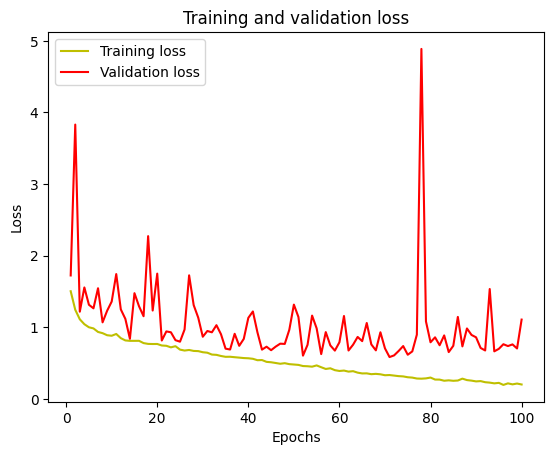

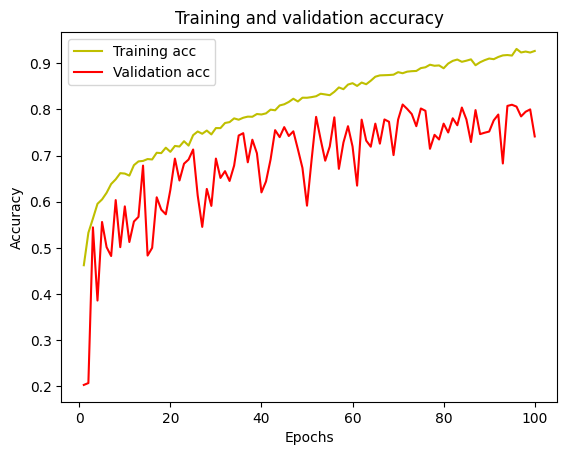

In [11]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
score = model.evaluate(X_val, y_val, verbose = 0 )
print("validation accuracy: ", score[1])

validation accuracy:  0.7434343695640564


# Confusion Matrix

62/62 [==============================] - 6s 55ms/step


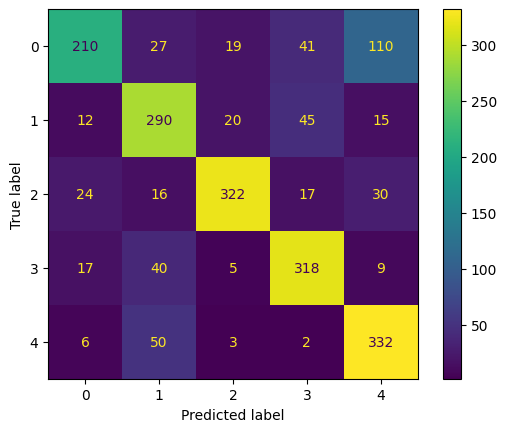

In [13]:
# If your test_labels are one-hot encoded, convert them to integer labels
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import numpy as np

val_integer_labels = np.argmax(y_val, axis=1)

# Get model predictions
predictions = model.predict(X_val)

# If your predictions are one-hot encoded, convert them to integer labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(val_integer_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
#plt.show()

# **Test**

In [14]:
image_files = os.listdir(test_path)
X_test = []
image_coulmn=[]

for img in os.listdir(test_path):
    image_coulmn.append(int((img.split('.'))[0]))
    img = cv2.imread(test_path + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Preprocess the image if needed (e.g., resizing)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X_test.append(img)

# Convert the list of images to a NumPy array and normalization it
X_test = np.array(X_test)/255.0

In [19]:
Output=model.predict(X_test, batch_size=16, verbose=0)

In [20]:
Predition_classes=[]
for predict in Output:
    index=np.argmax(predict)
    Predition_classes.append(index+1)

In [21]:
Predition_classes

[3,
 4,
 5,
 2,
 2,
 2,
 5,
 5,
 4,
 5,
 3,
 2,
 2,
 5,
 2,
 3,
 4,
 3,
 3,
 1,
 4,
 5,
 5,
 4,
 2,
 1,
 1,
 5,
 4,
 1,
 5,
 5,
 1,
 3,
 4,
 3,
 5,
 5,
 4,
 2,
 3,
 5,
 2,
 3,
 2,
 5,
 4,
 5,
 4,
 4,
 2,
 3,
 5,
 2,
 4,
 4,
 5,
 3,
 1,
 5,
 2,
 2,
 5,
 1,
 2,
 3,
 2,
 2,
 4,
 1,
 3,
 3,
 2,
 5,
 2,
 1,
 2,
 2,
 5,
 2,
 5,
 4,
 2,
 5,
 5,
 4,
 4,
 4,
 2,
 3,
 1,
 3,
 4,
 4,
 4,
 2,
 5,
 2,
 3,
 2]

In [22]:
# # Create a dictionary with two columns
# data = {'image_id': image_coulmn,
#         'label': Predition_classes}

# # Create a DataFrame from the dictionary
# df = pd.DataFrame(data)

# # Print the DataFrame
# print(df)

# df.to_csv('file1.csv',header=False,index=False)
